In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


In [2]:
df = pd.read_csv('./heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
TARGET_COL = "HeartDisease"
df.columns = [c.strip() for c in df.columns]

# recognize column type
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != TARGET_COL]
cat_cols = [c for c in df.columns if (not pd.api.types.is_numeric_dtype(df[c])) and c != TARGET_COL]

# 如果目标列缺失或不是二元，尝试自动猜测一个二元列（可选）
if TARGET_COL not in df.columns:
    candidates = [c for c in df.columns if df[c].nunique()==2]
    if candidates:
        TARGET_COL = candidates[0]
    else:
        raise ValueError("未找到目标列，请设置 TARGET_COL")

print("Target:", TARGET_COL)
print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)

Target: HeartDisease
Numeric features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [4]:
desc = df[num_cols].describe().T
print("\n[Univariate] Numeric describe:\n", desc)


[Univariate] Numeric describe:
              count        mean         std   min     25%    50%    75%    max
Age          918.0   53.510893    9.432617  28.0   47.00   54.0   60.0   77.0
RestingBP    918.0  132.396514   18.514154   0.0  120.00  130.0  140.0  200.0
Cholesterol  918.0  198.799564  109.384145   0.0  173.25  223.0  267.0  603.0
FastingBS    918.0    0.233115    0.423046   0.0    0.00    0.0    0.0    1.0
MaxHR        918.0  136.809368   25.460334  60.0  120.00  138.0  156.0  202.0
Oldpeak      918.0    0.887364    1.066570  -2.6    0.00    0.6    1.5    6.2


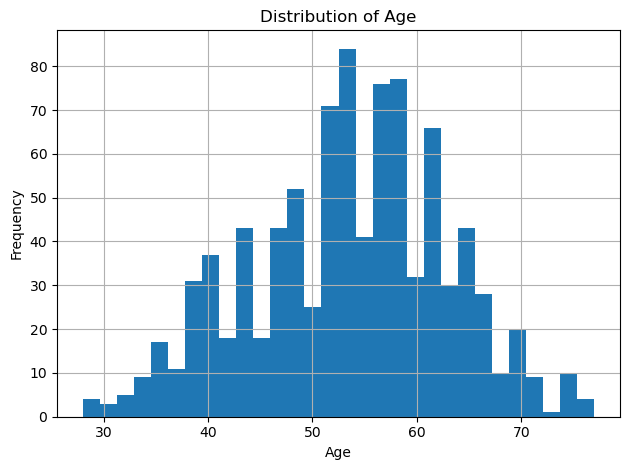

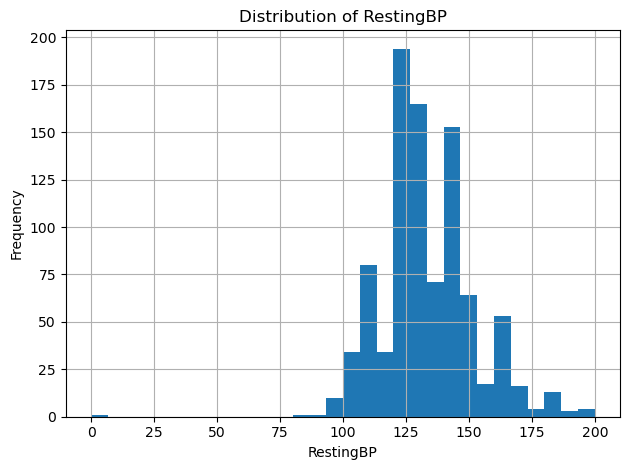

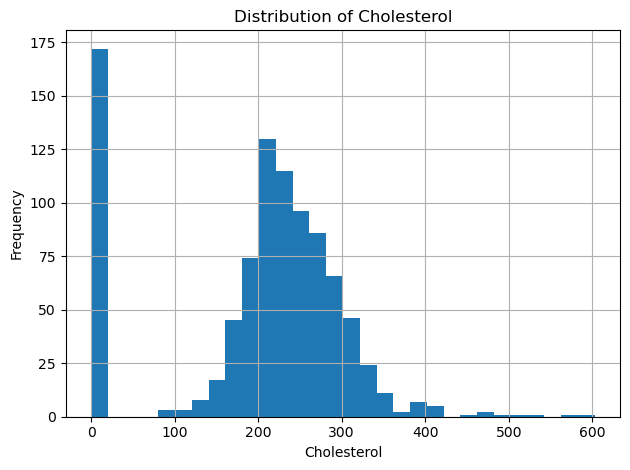

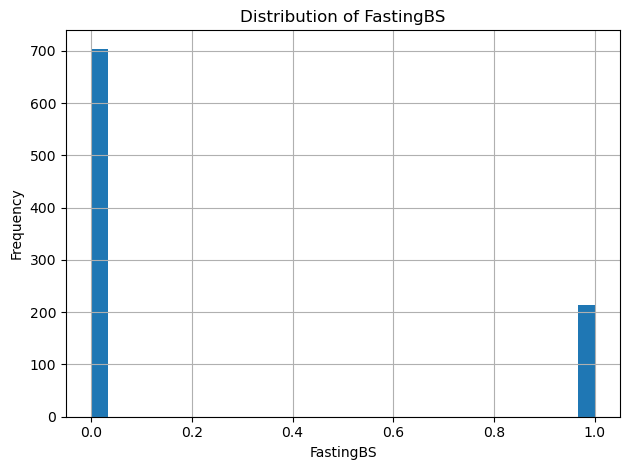

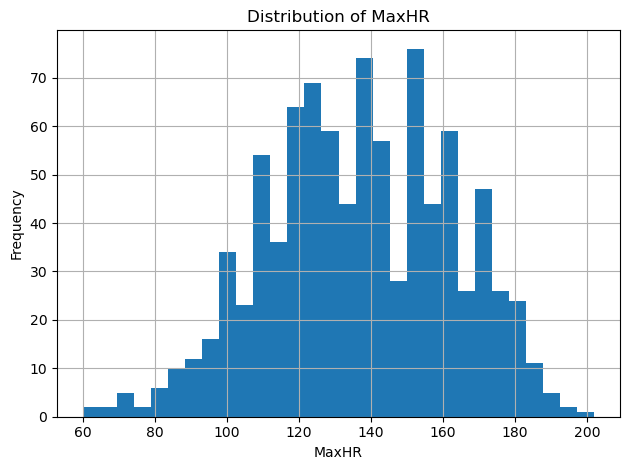

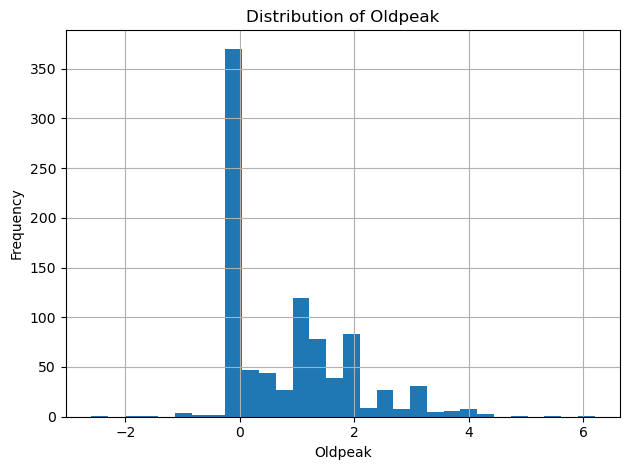

In [ ]:
# numerical column distribution
for c in num_cols:
    plt.figure()
    df[c].dropna().hist(bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


[Univariate] Categorical Sex value counts:
Sex
M    725
F    193
Name: count, dtype: int64


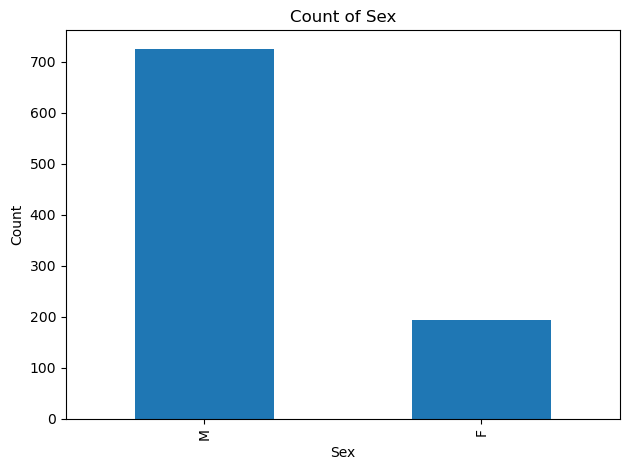


[Univariate] Categorical ChestPainType value counts:
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64


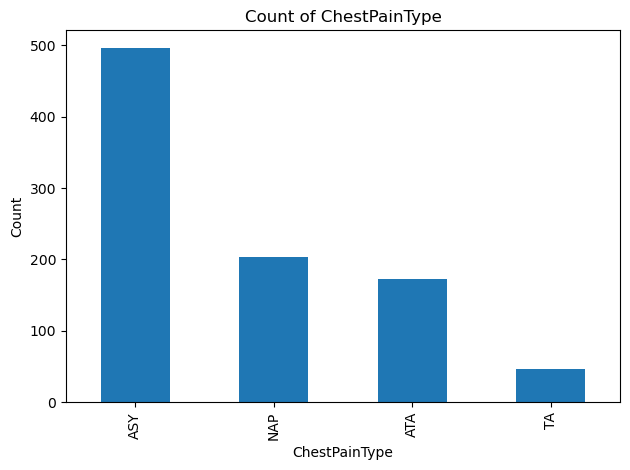


[Univariate] Categorical RestingECG value counts:
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64


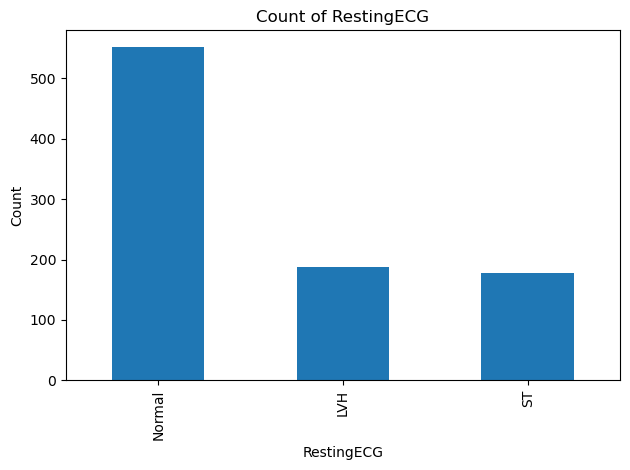


[Univariate] Categorical ExerciseAngina value counts:
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64


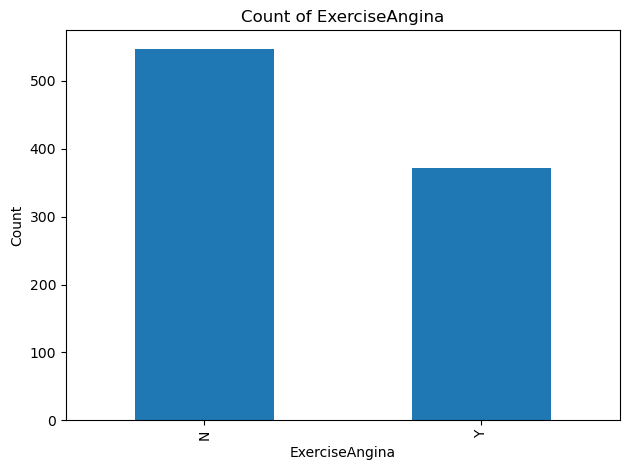


[Univariate] Categorical ST_Slope value counts:
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64


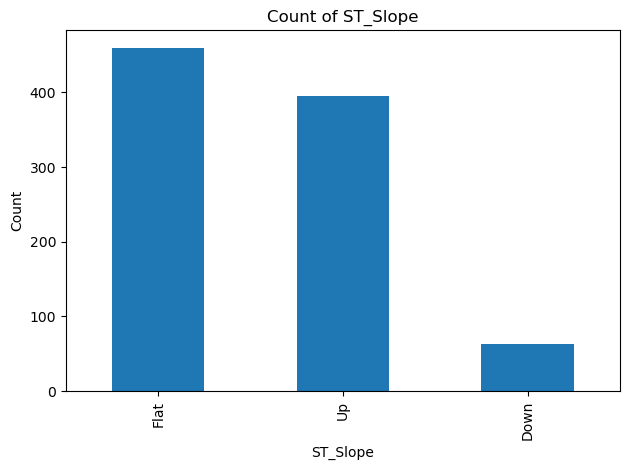

In [8]:
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    print(f"\n[Univariate] Categorical {c} value counts:\n{vc}")
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"Count of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

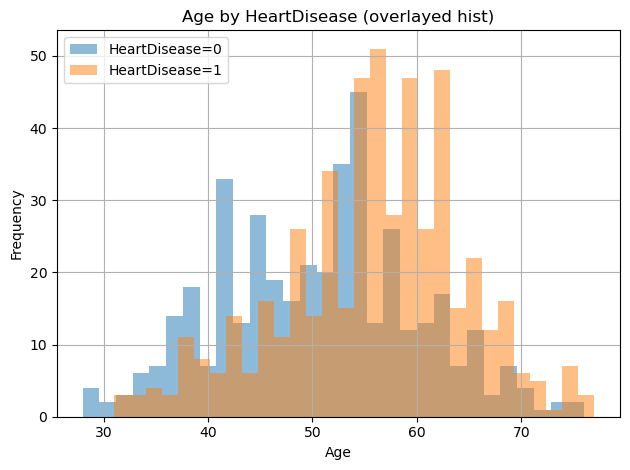

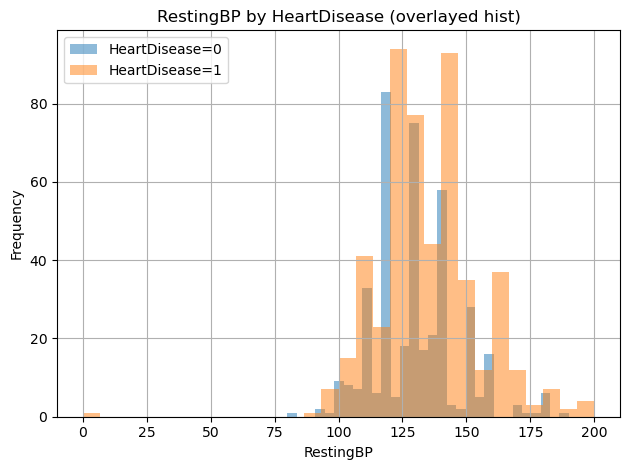

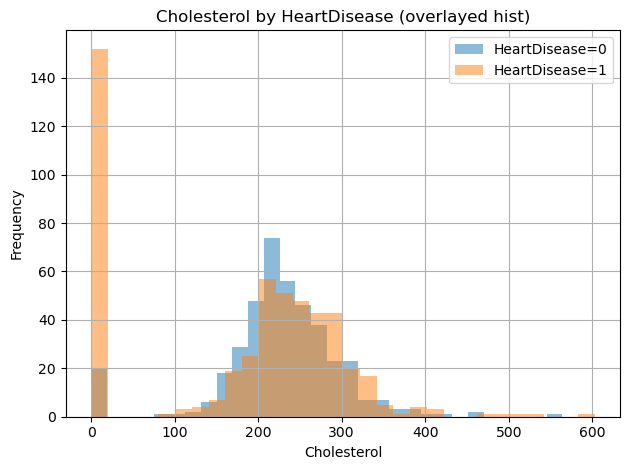

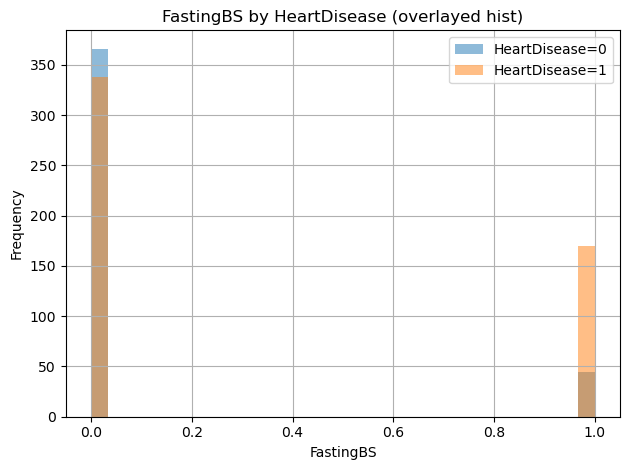

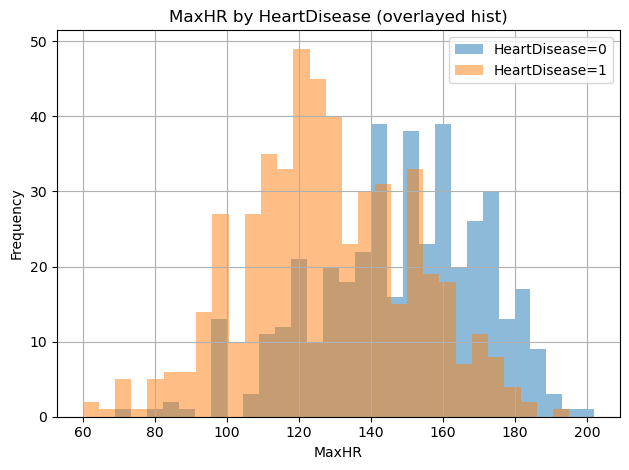

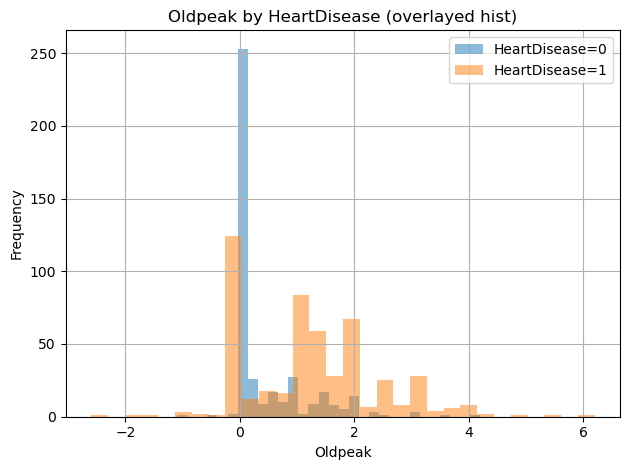


[Bivariate] Numeric vs target (t-test):
        feature     mean_y0     mean_y1     t_stat       p_value
5      Oldpeak    0.408049    1.274213 -14.040031  1.902722e-40
4        MaxHR  148.151220  127.655512  13.231478  1.430637e-36
0          Age   50.551220   55.899606  -8.822540  6.348337e-18
3    FastingBS    0.107317    0.334646  -8.760286  9.852286e-18
2  Cholesterol  227.121951  175.940945   7.626851  6.481236e-14
1    RestingBP  130.180488  134.185039  -3.339492  8.732265e-04


In [11]:
# ==========================================
# 6) Bivariate — 特征 vs 目标（binary target）
# ==========================================

y = df[TARGET_COL]

# 6.1 数值特征 vs 目标：组均值 + t-test + 叠加直方图
biv_numeric_report = []

for c in num_cols:
    g0 = df.loc[y==0, c].dropna()
    g1 = df.loc[y==1, c].dropna()
    # 组均值与t检验
    m0, m1 = g0.mean(), g1.mean()
    tstat, pval = stats.ttest_ind(g0, g1, equal_var=False, nan_policy="omit")
    biv_numeric_report.append((c, m0, m1, tstat, pval))
    
    # 叠加直方图（两组各一张曲线，不指定颜色）
    plt.figure()
    g0.hist(bins=30, alpha=0.5, label=f"{TARGET_COL}=0")
    g1.hist(bins=30, alpha=0.5, label=f"{TARGET_COL}=1")
    plt.title(f"{c} by {TARGET_COL} (overlayed hist)")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

biv_num_df = pd.DataFrame(biv_numeric_report, columns=["feature","mean_y0","mean_y1","t_stat","p_value"])
print("\n[Bivariate] Numeric vs target (t-test):\n", biv_num_df.sort_values("p_value").head(10))

<Figure size 640x480 with 0 Axes>

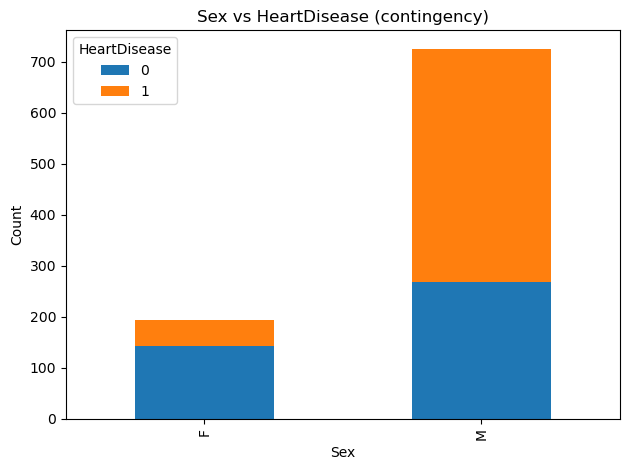

<Figure size 640x480 with 0 Axes>

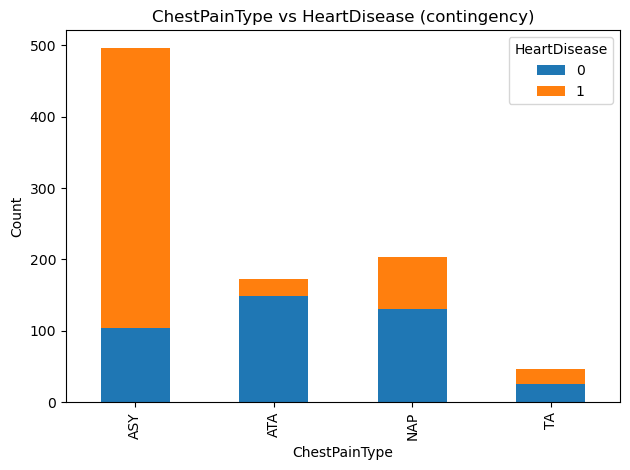

<Figure size 640x480 with 0 Axes>

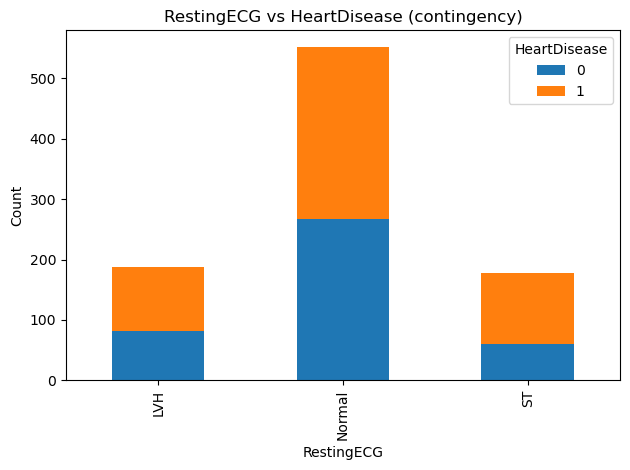

<Figure size 640x480 with 0 Axes>

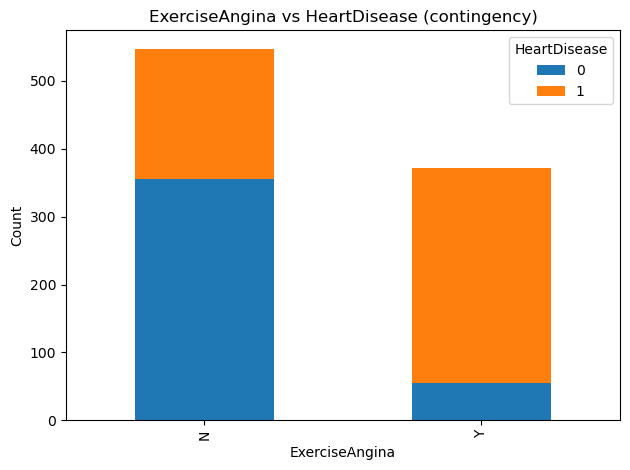

<Figure size 640x480 with 0 Axes>

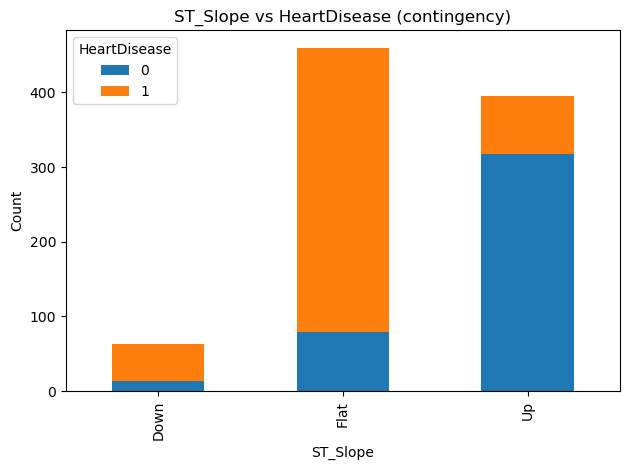


[Bivariate] Categorical vs target (chi-square):
           feature        chi2       p_value  dof
4        ST_Slope  355.918443  5.167638e-78    2
1   ChestPainType  268.067239  8.083728e-58    3
3  ExerciseAngina  222.259383  2.907808e-50    1
0             Sex   84.145101  4.597617e-20    1
2      RestingECG   10.931469  4.229233e-03    2


In [16]:
# 6.2 分类型特征 vs 目标：列联表 + chi-square
from scipy.stats import chi2_contingency

biv_cat_report = []
for c in cat_cols:
    ct = pd.crosstab(df[c], y)
    if ct.shape[0] > 1:  # 至少两个类别
        chi2, p, dof, _ = chi2_contingency(ct)
        biv_cat_report.append((c, chi2, p, dof))
        
        # 简单堆叠条形图
        plt.figure()
        ct.plot(kind="bar", stacked=True)
        plt.title(f"{c} vs {TARGET_COL} (contingency)")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

if biv_cat_report:
    biv_cat_df = pd.DataFrame(biv_cat_report, columns=["feature","chi2","p_value","dof"])
    print("\n[Bivariate] Categorical vs target (chi-square):\n", biv_cat_df.sort_values("p_value").head(10))


[Correlation] Pearson (numeric-numeric):
                   Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak
Age          1.000000   0.254399    -0.095282   0.198039 -0.382045  0.258612
RestingBP    0.254399   1.000000     0.100893   0.070193 -0.112135  0.164803
Cholesterol -0.095282   0.100893     1.000000  -0.260974  0.235792  0.050148
FastingBS    0.198039   0.070193    -0.260974   1.000000 -0.131438  0.052698
MaxHR       -0.382045  -0.112135     0.235792  -0.131438  1.000000 -0.160691
Oldpeak      0.258612   0.164803     0.050148   0.052698 -0.160691  1.000000


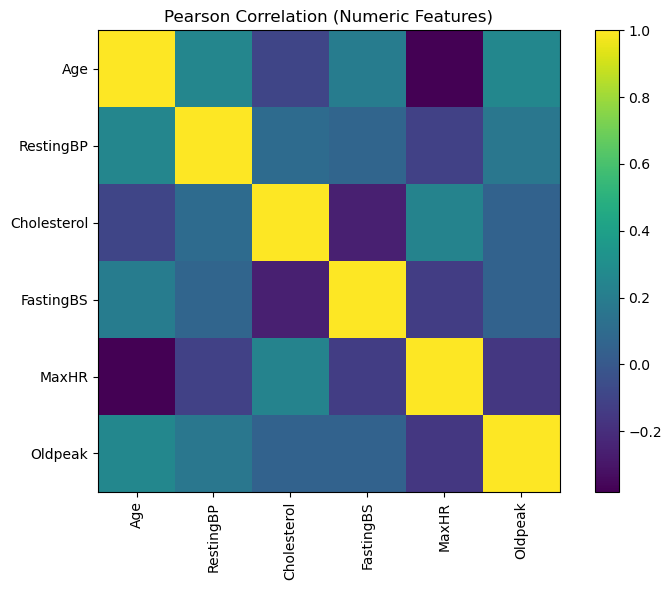


[Correlation] Cramér's V top categorical pairs:
              cat1            cat2  cramers_v
0  ExerciseAngina        ST_Slope   0.321557
1   ChestPainType  ExerciseAngina   0.253407
2   ChestPainType        ST_Slope   0.234445
3             Sex  ExerciseAngina   0.185117
4             Sex   ChestPainType   0.111090
5             Sex        ST_Slope   0.103995
6   ChestPainType      RestingECG   0.069747
7      RestingECG  ExerciseAngina   0.068587
8      RestingECG        ST_Slope   0.044901
9             Sex      RestingECG   0.039326


In [17]:
# ==========================================
# 7) Correlation — 特征 vs 特征
# ==========================================

# 7.1 数值-数值：皮尔逊相关矩阵 + 可视化
if len(num_cols) >= 2:
    corr = df[num_cols].corr(method="pearson")
    print("\n[Correlation] Pearson (numeric-numeric):\n", corr)
    
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation='nearest')
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title("Pearson Correlation (Numeric Features)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# 7.2 类别-类别：Cramér's V（可选）
#   说明：这里给出一个小工具函数，计算每对类别特征的Cramér's V，并打印Top若干对。
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # 修正（Bias correction）
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / max((kcorr-1), (rcorr-1)))

cat_pairs = []
for i in range(len(cat_cols)):
    for j in range(i+1, len(cat_cols)):
        ct = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]])
        if ct.shape[0] >= 2 and ct.shape[1] >= 2:
            v = cramers_v(ct)
            cat_pairs.append((cat_cols[i], cat_cols[j], v))

if cat_pairs:
    cat_pairs_sorted = sorted(cat_pairs, key=lambda x: -x[2])
    print("\n[Correlation] Cramér's V top categorical pairs:\n", pd.DataFrame(cat_pairs_sorted[:10], columns=["cat1","cat2","cramers_v"]))